# nodebook 09b: Optimizer tweaks

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import torch
def cuda(self, device=None, non_blocking=False) :
    #let me be on my mac
    return self
torch.Tensor.cuda = cuda

In [3]:
from exp.nb_09 import *
from functools import partial

## Learner

In [4]:
from enum import Enum,auto

class Event():
    def __init__(self,learner:Learner):
        self.learn = learner
        
class Callback():
    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')

class Stages(Enum):
    begin_fit = auto()
    begin_epoch = auto()
    begin_batch = auto()
    begin_prediction = auto()
    after_prediction = auto()
    begin_loss = auto()
    after_loss = auto()
    begin_backwards = auto()
    after_backwards = auto()
    begin_step = auto()
    after_step = auto()
    after_batch = auto()
    after_epoch = auto()
    after_fit = auto()
    begin_validate = auto()
    after_validate = auto()  
    begin_train = auto()
    after_train = auto()  
    
train_batch_stages = [Stages.begin_prediction, Stages.after_prediction,
                      Stages.begin_loss,       Stages.after_loss,
                      Stages.begin_backwards,  Stages.after_backwards,
                      Stages.begin_step,       Stages.after_step ]
valid_batch_stages = [Stages.begin_prediction, Stages.after_prediction,
                      Stages.begin_loss,       Stages.after_loss ]
    

In [5]:
class Messenger():
    subscriptions = []    
        
    # cbs is instances of Callback whereas cb_funcs are functions that initializes a Callback 
    def register( self, cb:Callback ): self.subscriptions.append(cb)
        
    def register_callback_functions( self, cb_funcs ):
        for cbf in listify(cb_funcs): self.register(cbf())
        
    def notify(self, msg:Stages, event):
        for cb in self.subscriptions: 
            f = getattr(cb, msg.name, None)
            if f is not None and not event.learn.stop: 
                #print(f"in_train: {event.learn.in_train } callback: {type(cb).__name__}.{msg.name}")            
                f(event)
            if event.learn.stop:break
                
#are we missing a begin_train that match begin_validate??????
class Learner():
    msn      = Messenger()
    in_train = False
    n_epochs = 0
    epochs   = 0
    loss     = -1
    
    def __init__(self, model, data, loss_func, opt, cb_funcs):
        self.model,self.data,self.loss_func,self.opt = model,data,loss_func,opt
        self.msn.register_callback_functions(cb_funcs)
        #for cb in listify(cbs): self.msn.register(cb)
        self._stop = False

    def find_subcription_by_cls(self,cls):
        for s in learn.msn.subscriptions:
            if type(s) == cls:return s
        
    @property
    def stop(self): return self._stop
    @stop.setter 
    def stop(self, value): 
        if not self._stop : self._stop = value 

    def fit(self, epochs):
        self.epochs, self.loss = epochs, tensor(0.)
        event = Event(self)
        try:
            self.msn.notify(Stages.begin_fit,event)
            for epoch in range(epochs):
                if self.stop: break
                print(f"epoch: {epoch}")
                    
                self.epoch = epoch
                self.msn.notify(Stages.begin_epoch,event)
                
                self.in_train = True
                self.msn.notify(Stages.begin_train,event)
                self.all_batches(train_batch_stages, self.data.train_dl)
                self.msn.notify(Stages.after_train,event)
                self.in_train = False
                
                with torch.no_grad():
                    self.msn.notify(Stages.begin_validate,event)
                    self.all_batches(valid_batch_stages, self.data.valid_dl)
                    self.msn.notify(Stages.after_validate,event)
                        
                self.msn.notify(Stages.after_epoch,event)
        except Exception as e: self.exception_handler(e)
        finally: self.msn.notify(Stages.after_fit,event)
            
        
    def all_batches(self, batch_stages, dl):
        ite_count, self.iters = 0, len(dl)
        try:
            for xb,yb in dl: 
                if self.stop: break
                self.one_batch(batch_stages, xb, yb)
                ite_count+=1
                p = (100*ite_count)//self.iters
                if p%10==0 : print(f"{p} %")
        except Exception as e: self.exception_handler(e)
                            
    def one_batch(self, batch_stages, xb, yb):
        event = Event(self)        
        try:
            self.xb,self.yb = xb,yb
            self.msn.notify(Stages.begin_batch,event)
            for msg in batch_stages: 
                self.msn.notify(msg,event)
        except Exception as e: self.exception_handler(e)
        finally: self.msn.notify(Stages.after_batch,event)

    def exception_handler(self, e:Exception ):
        self.stop = True
        import traceback
        print("exception: {e}")
        tb = traceback.format_exc()            
        print(f"exception received 3\n:{tb}")
        

## Callbacks

In [6]:
class AvgStats():
    def __init__(self, metrics, in_train): self.metrics,self.in_train = listify(metrics),in_train

    def reset(self):
        self.tot_loss,self.count = 0.,0
        self.tot_mets = [0.] * len(self.metrics)

    @property
    def all_stats(self): return [self.tot_loss.item()] + self.tot_mets
    @property
    def avg_stats(self): return [o/self.count for o in self.all_stats]

    def __repr__(self):
        if not self.count: return ""
        return f"{'train' if self.in_train else 'valid'}: {self.avg_stats}"

    def accumulate(self, learn):
        bn = learn.xb.shape[0]
        self.tot_loss += learn.loss * bn
        self.count += bn
        for i,m in enumerate(self.metrics):
            self.tot_mets[i] += m(learn.preds, learn.yb) * bn


In [7]:
class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats, self.valid_stats = AvgStats(metrics,True), AvgStats(metrics,False)

    def begin_epoch(self, e:Event):
        self.train_stats.reset()
        self.valid_stats.reset()

    def after_loss(self, e:Event):
        stats = self.train_stats if e.learn.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(e.learn)

    def after_epoch(self, e:Event):
        print(self.train_stats)
        print(self.valid_stats)
        
        
class Recorder(Callback):   
    def begin_fit(self, e:Event):
        self.lrs = [[] for _ in e.learn.opt.param_groups]
        self.losses = []

    def after_batch(self, e:Event):
        if e.learn.in_train:         
            for pg,lr in zip(e.learn.opt.param_groups, self.lrs): lr.append(pg['lr'])
            self.losses.append(e.learn.loss.detach().cpu())

    def plot_lr  (self, pgid=-1): plt.plot(self.lrs[pgid])
    def plot_loss(self):          plt.plot(self.losses)

        
class CudaCallback(Callback):
    def begin_fit(self, e:Event): e.learn.model.cuda()
        
    def begin_batch(self, e:Event): e.learn.xb,e.learn.yb = e.learn.xb.cuda(),e.learn.yb.cuda()

        
class BatchTransformXCallback(Callback):
    def __init__(self, tfm): self.tfm = tfm
    def begin_batch(self, e:Event): e.learn.xb = self.tfm(e.learn.xb)

        
#must always be used for training        
class TrainableModelCallback(Callback):
    def begin_prediction(self,e:Event): e.learn.preds = e.learn.model(e.learn.xb)

    def begin_backwards(self,e:Event): 
        if e.learn.in_train: e.learn.loss.backward()
    
    def begin_loss(self,e:Event): e.learn.loss = e.learn.loss_func(e.learn.preds, e.learn.yb)

#must always be used for training        
class TrainEvalCallback(Callback):
    def begin_train(self,e:Event): 
        if e.learn.in_train: e.learn.model.train()

    def begin_validate(self, e:Event): e.learn.model.eval()
      
 #must always be used for training        
class ParamScheduler(Callback):
    def __init__(self, pname, sched_funcs): self.pname, self.sched_funcs = pname,sched_funcs

    def begin_fit(self,e:Event):
        #count iteration to adjust the training params to the progress in the training cycle
        self.n_iter = 0
        
        if not isinstance(self.sched_funcs, (list,tuple)):
            self.sched_funcs = [self.sched_funcs] * len(e.learn.opt.param_groups)
            
    def set_param(self, e):
        assert len(e.learn.opt.param_groups)==len(self.sched_funcs)
        fractional_cycle = min(1.,self.n_iter /(e.learn.iters * e.learn.epochs))
        for pg,f in zip(e.learn.opt.param_groups,self.sched_funcs):
            pg[self.pname] = f(fractional_cycle)

    def begin_batch(self,e:Event): 
        if e.learn.in_train: self.set_param(e)       

    def after_batch(self,e:Event): 
        if e.learn.in_train: self.n_iter += 1

#used for alle training
class OptimizerCallback(Callback):
    def begin_step(self, e:Event):
        if e.learn.in_train: e.learn.opt.step()
            
    def after_step(self, e:Event):            
        if e.learn.in_train: e.learn.opt.zero_grad()   
            

## Other functions

## MNIST

In [8]:
#export
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
    def forward(self, x): return self.func(x)
    
def flatten(x):      return x.view(x.shape[0], -1)

#This one takes the flat vector of size `bs x 784` and puts it back as a batch of images of 28 by 28 pixels:
def mnist_resize(x): return x.view(-1, 1, 28, 28)

In [9]:
def get_mnist_cnn_model(data, output_features):
    return nn.Sequential(
        Lambda(mnist_resize),
        nn.Conv2d( 1, 8, 5, padding=2,stride=2), nn.ReLU(), #14
        nn.Conv2d( 8,16, 3, padding=1,stride=2), nn.ReLU(), # 7
        nn.Conv2d(16,32, 3, padding=1,stride=2), nn.ReLU(), # 4
        nn.Conv2d(32,32, 3, padding=1,stride=2), nn.ReLU(), # 2
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32,output_features)
    )

In [10]:
x_train,y_train,x_valid,y_valid = get_data()
x_train,x_valid   = normalize_to(x_train,x_valid)

x_train.mean(),x_train.std()

(tensor(0.0001), tensor(1.))

In [11]:
nh,bs, output_features = 50,512,y_train.max().item()+1
train_ds,valid_ds      = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
train_dl, valid_dl     = ( DataLoader( train_ds, batch_size=bs, shuffle=True), 
                           DataLoader(valid_ds,  batch_size=bs*2) )
data                   = DataBunch( train_dl, valid_dl )

In [12]:
model     = get_mnist_cnn_model(data, output_features)
loss_func = F.cross_entropy
opt       = torch.optim.SGD(model.parameters(), lr=0.01)
sched     = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 
cbfs      = [TrainableModelCallback, TrainEvalCallback, OptimizerCallback, partial(ParamScheduler, 'lr', sched),
             Recorder, partial(AvgStatsCallback,accuracy)]

learn     = Learner( model, data, loss_func, opt=opt, cb_funcs=cbfs)

In [13]:
%time learn.fit(3)

epoch: 0
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100 %
train: [2.218865, tensor(0.1887)]
valid: [1.950932421875, tensor(0.3103)]
epoch: 1
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100 %
train: [0.842150703125, tensor(0.7189)]
valid: [0.2488197998046875, tensor(0.9269)]
epoch: 2
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100 %
train: [0.21651556640625, tensor(0.9344)]
valid: [0.15874683837890624, tensor(0.9517)]
CPU times: user 30.6 s, sys: 401 ms, total: 31 s
Wall time: 10.5 s


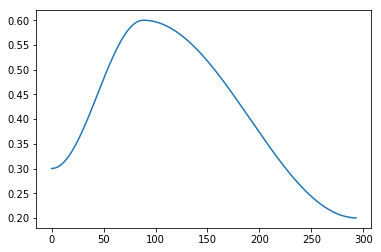

tensor(0.1716)

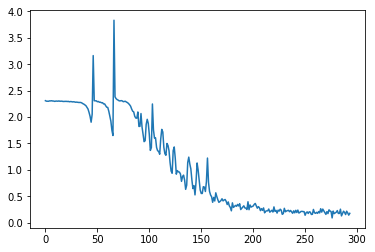

In [14]:
learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_loss()
learn.loss

## Imagenette data

In [15]:
def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    init_cnn_(m, f)
    return m

In [16]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)

In [17]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]
il   = ImageItemList.from_files(path, tfms=tfms)
sd   = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll   = label_by_func(sd, parent_labeler)
bs   = 64

#train_dl,valid_dl = get_dls(ll.train,ll.valid, bs, num_workers=4)
train_dl,valid_dl = ( DataLoader(ll.train, batch_size=bs,   num_workers=4, shuffle=True),
                      DataLoader(ll.valid, batch_size=bs*2, num_workers=4))

In [18]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 
cbfs = [TrainableModelCallback, TrainEvalCallback, OptimizerCallback, partial(ParamScheduler, 'lr', sched),
        partial(BatchTransformXCallback, norm_imagenette),
        Recorder, partial(AvgStatsCallback,accuracy),
        #CudaCallback,
       ]

In [19]:
data = DataBunch(train_dl, valid_dl, 3, 10)

In [20]:
layers_sizes = [32]*4

In [21]:
model = init_cnn( get_cnn_model(data, layers_sizes, conv_layer) )
opt   = torch.optim.SGD(model.parameters(), lr=0.5)
learn = Learner( model, data, loss_func=F.cross_entropy, opt=opt, cb_funcs=cbfs)

In [22]:
%time learn.fit(1)

epoch: 0
exception: {e}
exception received 3
:Traceback (most recent call last):
  File "<ipython-input-5-9880ca97098f>", line 87, in one_batch
    self.msn.notify(msg,event)
  File "<ipython-input-5-9880ca97098f>", line 15, in notify
    f(event)
  File "<ipython-input-7-97faddfeea94>", line 48, in begin_backwards
    if e.learn.in_train: e.learn.loss.backward()
  File "/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/tensor.py", line 102, in backward
    torch.autograd.backward(self, gradient, retain_graph, create_graph)
  File "/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/autograd/__init__.py", line 90, in backward
    allow_unreachable=True)  # allow_unreachable flag
RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.

0 %
CPU times: user 4.57 s, sys: 1.28 s, total: 5.86 s
Wall time: 5.65 s


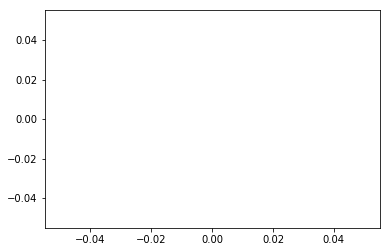

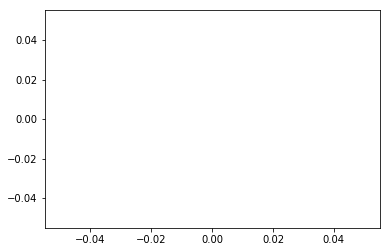

tensor(2.4465, grad_fn=<NllLossBackward>)

In [23]:
learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_loss(),plt.show()
learn.loss

## Export